<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/1.2-DNN_2_6kx6k-tfidf-200k-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Layer DNN 6k x 6k TFIDF Prototype

Trying out a 2 layer network using word2vec average embedding. Embedding was creating with word_context == 5
Recommendation that I read for NN is the number of neurons should not exceed 2/3 of the number of features which would be around 340 for 512 features



Number of hidden layers guidelines:

* none - Only capable of representing linear separable functions or decisions.
* 1	- Can approximate any function that contains a continuous mapping from one finite space to another.
* 2	- Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.
* 2+ - Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.


Hidden units guidelines:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

https://www.heatonresearch.com/2017/06/01/hidden-layers.html


Since our decision boundaries do not look linear, I have chosen to use 2 hidden layers. For each layer, there is the same number of hiddent units (10k) as input features.

Number of samples: 50k



In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import importlib
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from util import dict_util as du
from util import file_util as fu
from util import plot_util as pu
from util import keras_util as ku
import util.report_util as ru


import pickle
import json
from datetime import datetime
import os

import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()

Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_DIR = f"{DRIVE_DIR}/data"
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"
RSTATE = 1
EPOCH=200
BATCH_SIZE = 128
EMBED_SIZE = 0
PATIENCE=8

DEBUG = False

MODEL_NAME = "DNN"
ARCHITECTURE = "2_1.5x1"
FEATURE_SET_NAME = "tfidf_ngram13"
DESCRIPTION = "2 Layer NN with the following hidden units - layer 1: 6k, layer 2: 6k"
if DEBUG:
  DATA_FILE = f'{DATA_DIR}/review_body-word2vec-df_none-ngram_none-89-100-nolda.csv'
  MODEL_NAME = f"test-{MODEL_NAME}"
else:
  DATA_FILE = f'{DATA_DIR}/review_body-tfidf-df_none-ngram13-199134-4000-nolda.csv'

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{MODEL_NAME}-{ARCHITECTURE}-nobatch-{INBASENAME}-sampling_none-{FEATURE_COLUMN}"


In [0]:
df = pd.read_csv(f"{DATA_FILE}")
rating = df[LABEL_COLUMN]
df = df.drop(columns=["helpful_votes", "total_votes", "helpful_product", "star_rating"])

In [0]:
df.head()

,ability,able,able charge,able get,able use,absolute,absolutely,absolutely love,absolutely love case,absolutely no,abuse,ac,accept,acceptable,access,accessible,accessory,accident,accidentally,according,account,accuracy,accurate,across,act,action,activate,activated,active,activity,actual,actually,actually work,ad,adapter,adaptor,add,add bulk,add much,added,...,would probably,would purchase,would rather,would recommend,would recommend anyone,would recommend case,would recommend product,would say,would still,would suggest,would take,would think,would work,wouldnt,wow,wrap,wrap around,wrist,write,write review,writing,written,wrong,wrote,xm,yeah,year,year ago,year old,year still,yellow,yes,yesterday,yet,youtube,youtube video,yr,zagg,zero,zune
0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
rating.head()

0    3
1    5
2    5
3    5
4    1
Name: star_rating, dtype: int64

In [0]:



model = Sequential()

model.add(Dense(1.5 * df.shape[1], input_shape=(df.shape[1],), kernel_initializer='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1.5 * df.shape[1], kernel_initializer='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='relu'))
model.add(Activation('softmax'))
# model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=[custom_metric])
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6000)              24006000  
_________________________________________________________________
activation (Activation)      (None, 6000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6000)              36006000  
_________________________________________________________________
activation_1 (Activation)    (None, 6000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3

In [0]:
# one hot encode rating
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y[:5]

(199134,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=1)

In [0]:
import tensorflow.keras as keras
import numpy as np
import sklearn.metrics as sklm



# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)

# metric = Metrics()

mw = ku.ModelWrapper(model, MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=None,
                     description=DESCRIPTION)

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')

network_history = mw.fit(x_train, 
                         y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCH,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.43633872 3.07851898 2.18840596 1.19528211 0.3723871 ]
Number of training examples: 149350


Train on 119480 samples, validate on 29870 samples
Epoch 1/200
119480/119480 [==============================] - 33s 275us/sample - loss: 1.3490 - categorical_accuracy: 0.5359 - val_loss: 1.3081 - val_categorical_accuracy: 0.5383
Epoch 2/200
119480/119480 [==============================] - 32s 265us/sample - loss: 1.2944 - categorical_accuracy: 0.5368 - val_loss: 1.2817 - val_categorical_accuracy: 0.5383
Epoch 3/200
119480/119480 [==============================] - 32s 264us/sample - loss: 1.2696 - categorical_accuracy: 0.5368 - val_loss: 1.2536 - val_categorical_accuracy: 0.5383
Epoch 4/200
119480/119480 [==============================] - 32s 264us/sample - loss: 1.2313 - categorical_accuracy: 0.5368 - val_loss: 1.2028 - val_categorical_accuracy: 0.5397
Epoch 5/200
119480/119480 [==============================] - 31s 261us/sample - loss: 1.1713 - categorical_accuracy: 0.5531 - val_loss: 1.1356 - val_categorical_accuracy: 0.5747
Epoch 6/200
119480/119480 [==============================] 

In [0]:
scores = mw.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Number of test: 49784
Running model.evaluate...


49784/49784 [==============================] - 6s 116us/sample - loss: 0.8035 - categorical_accuracy: 0.6871
Running model.predict...


Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 68.71%


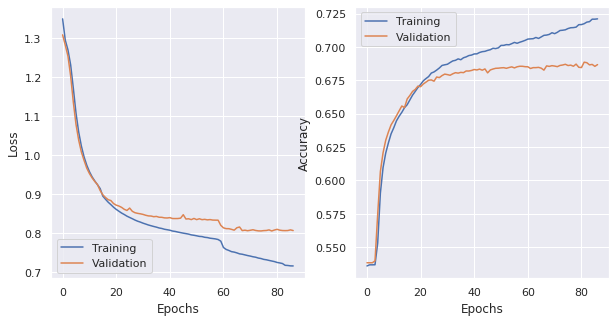

In [0]:

importlib.reload(pu)
pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")


In [0]:

mw.confusion_matrix

array([[ 5796,   120,   482,    88,   495],
       [ 1747,   162,   731,   198,   387],
       [  974,   120,  1520,   848,  1078],
       [  313,    35,   864,  2297,  4789],
       [  501,    11,   443,  1352, 24433]])

In [0]:
# print(classification_report(y_test_unencoded, y_predict_unencoded))
print(mw.classification_report)


              precision    recall  f1-score   support

           1       0.62      0.83      0.71      6981
           2       0.36      0.05      0.09      3225
           3       0.38      0.33      0.35      4540
           4       0.48      0.28      0.35      8298
           5       0.78      0.91      0.84     26740

    accuracy                           0.69     49784
   macro avg       0.52      0.48      0.47     49784
weighted avg       0.65      0.69      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

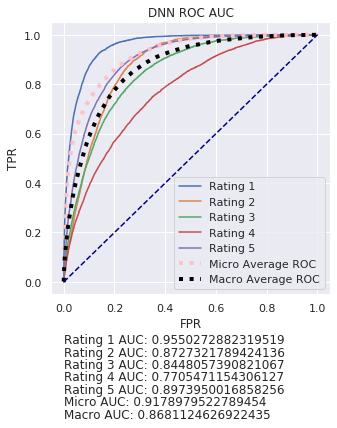

In [0]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)

In [0]:
print(f'Score {ru.calculate_metric(mw.crd)}')

INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate


Score 0.17248835726535203


# Save off various files

In [0]:
mw.save(DRIVE_DIR, append_report=True)


description: DNN-2_1.5x1-tfidf_ngram13-sampling_none-199134-4000-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/DNN-2_1.5x1-tfidf_ngram13-sampling_none-199134-4000-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/DNN-2_1.5x1-tfidf_ngram13-sampling_none-199134-4000-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/DNN-2_1.5x1-tfidf_ngram13-sampling_none-199134-4000-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'DNN', 'architecture': '2_1.5x1', 'description': 'DNN-2_1.5x1-nobatch-review_body-tfidf-df_none-ngram13-199134-4000-nolda-sampling_none-review_body', 'classification_report': '{"1": {"precision": 0.6211552888222055, "recall": 0.8302535453373442, "f1-score": 0.7106424717999018, "support": 6981}

In [0]:
print(datetime.now())

2019-11-07 20:12:33.755165
